# Testing ROS3 and fsspec with h5py on cloud optimized HDF5 files 

This notebook tests both I/O drivers on cloud optimized HDF5 files from the ICESat-2 mission. 

> Note: The ROS3 driver is only available in the Conda distribution of h5py

In [1]:
import xarray as xr
import h5py
import fsspec
import s3fs
import logging
import re
import time
import numpy as np
import zarr
import pandas as pd
import matplotlib.pyplot as plt


from h5coro import h5coro, s3driver, filedriver
driver =  s3driver.S3Driver

logger = logging.getLogger('fsspec')
logger.setLevel(logging.DEBUG)

for library in (xr, h5py, fsspec, h5coro, zarr):
    print(f'{library.__name__} v{library.__version__}')

xarray v2024.6.0
h5py v3.11.0
fsspec v2024.6.0
h5coro v0.0.6
zarr v2.18.2


In [2]:
test_dict = {
    "1GB": {
        "links": {
            "original": "s3://its-live-data/test-space/cloud-experiments/h5cloud/atl03/ATL03_20230618223036_13681901_006_01.h5",
            "original-kerchunk": "s3://its-live-data/test-space/cloud-experiments/h5cloud/atl03/ATL03_20230618223036_13681901_006_01.json",
            "page-only-4mb": "s3://its-live-data/test-space/cloud-experiments/h5cloud/atl03/ATL03_20230618223036_13681901_006_01-page-only-4mb.h5",
            "page-only-8mb": "s3://its-live-data/test-space/cloud-experiments/h5cloud/atl03/ATL03_20230618223036_13681901_006_01-page-only-4mb.h5",
            "rechunked-4mb": "s3://its-live-data/test-space/cloud-experiments/h5cloud/atl03/ATL03_20230618223036_13681901_006_01_rechunked-100k-page-4mb.h5",
            "rechunked-8mb": "s3://its-live-data/test-space/cloud-experiments/h5cloud/atl03/ATL03_20230618223036_13681901_006_01_rechunked-100k-page-8mb.h5",
            "rechunked-8mb-kerchunk": "s3://its-live-data/test-space/cloud-experiments/h5cloud/atl03/ATL03_20230618223036_13681901_006_01_rechunked-100k-page-8mb.json",
            
        },
        "group": "/gt1l/heights",
        "variable": "h_ph"
    },
    "7GB": {
        "links": {
            "original": "s3://its-live-data/test-space/cloud-experiments/h5cloud/atl03/ATL03_20181120182818_08110112_006_02.h5",
            "original-kerchunk": "s3://its-live-data/test-space/cloud-experiments/h5cloud/atl03/ATL03_20181120182818_08110112_006_02.json",
            "page-only-4mb": "s3://its-live-data/test-space/cloud-experiments/h5cloud/atl03/ATL03_20181120182818_08110112_006_02-page-only-4mb.h5",
            "page-only-8mb": "s3://its-live-data/test-space/cloud-experiments/h5cloud/atl03/ATL03_20181120182818_08110112_006_02-page-only-8mb.h5",
            "rechunked-4mb": "s3://its-live-data/test-space/cloud-experiments/h5cloud/atl03/ATL03_20181120182818_08110112_006_02_rechunked-100k-page-4mb.h5",
            "rechunked-8mb": "s3://its-live-data/test-space/cloud-experiments/h5cloud/atl03/ATL03_20181120182818_08110112_006_02_rechunked-100k-page-8mb.h5",
            "rechunked-8mb-kerchunk": "s3://its-live-data/test-space/cloud-experiments/h5cloud/atl03/ATL03_20181120182818_08110112_006_02_rechunked-100k-page-8mb.json",
        },
        "group": "/gt1l/heights",
        "variable": "h_ph"
    }
}

fs = s3fs.S3FileSystem(anon=True)

In [3]:
h5py_fsspec_benchmarks = []


for key, dataset in test_dict.items():
    for k, link in dataset["links"].items():
        try:
            if "kerchunk" in k or link.endswith(".json"):
                continue   
            print (f"Processing: {link}")
            log_filename = f"logs/fsspec-h5py-{key}-{k}_default.log"
            
            # Create a new FileHandler for each iteration
            file_handler = logging.FileHandler(log_filename)
            file_handler.setLevel(logging.DEBUG)

            # Add the handler to the root logger
            logging.getLogger().addHandler(file_handler)
            # this is mostly IO so no perf_counter is needed
            io_params = {
                "fsspec_params": {},
                "h5py_params": {}
            }
            
            if "rechunked" in link or "page" in link:
                io_params ={
                    "fsspec_params": {
                        "cache_type": "blockcache",
                        "block_size": 8*1024*1024
                    },
                    "h5py_params" : {
                        "page_buf_size": 32*1024*1024,
                        "rdcc_nbytes": 4*1024*1024
                    }
                }
            
            start = time.time()
            fo = fs.open(link, mode="rb", **io_params["fsspec_params"])
            with h5py.File(fo, **io_params["h5py_params"]) as f:
                path = f"{dataset['group']}/{dataset['variable']}"
                data = f[path][:]
                data_mean = data.mean()
                elapsed = time.time() - start
                h5py_fsspec_benchmarks.append(
                    {"tool": "h5py-fsspec",
                     "dataset": key,
                     "cloud-aware": "yes",
                     "format": k,
                     "file": link,
                     "time": elapsed,
                     "shape": data.shape,
                     "bytes_requested": fo.cache.total_requested_bytes,
                     "mean": data_mean})

                logging.getLogger().removeHandler(file_handler)      
                file_handler.close()
            
        except Exception as e:
            print(e)

Processing: s3://its-live-data/test-space/cloud-experiments/h5cloud/atl03/ATL03_20230618223036_13681901_006_01.h5
Processing: s3://its-live-data/test-space/cloud-experiments/h5cloud/atl03/ATL03_20230618223036_13681901_006_01-page-only-4mb.h5
Processing: s3://its-live-data/test-space/cloud-experiments/h5cloud/atl03/ATL03_20230618223036_13681901_006_01-page-only-4mb.h5
Processing: s3://its-live-data/test-space/cloud-experiments/h5cloud/atl03/ATL03_20230618223036_13681901_006_01_rechunked-100k-page-4mb.h5
Processing: s3://its-live-data/test-space/cloud-experiments/h5cloud/atl03/ATL03_20230618223036_13681901_006_01_rechunked-100k-page-8mb.h5
Processing: s3://its-live-data/test-space/cloud-experiments/h5cloud/atl03/ATL03_20181120182818_08110112_006_02.h5
Processing: s3://its-live-data/test-space/cloud-experiments/h5cloud/atl03/ATL03_20181120182818_08110112_006_02-page-only-4mb.h5
Processing: s3://its-live-data/test-space/cloud-experiments/h5cloud/atl03/ATL03_20181120182818_08110112_006_02-p

In [5]:
h5py_ros3_benchmarks = []

for key, dataset in test_dict.items():
    for k, link in dataset["links"].items():
        try:
            if "kerchunk" in k or link.endswith(".json"):
                continue
            print (f"Processing: {link}")

            h5py_params = {
                "mode": "r",
                "driver": "ros3",
                "aws_region": "us-west-2".encode("utf-8"),
            }

            
            if "rechunked" in link or "page" in link:
                h5py_params["page_buf_size"] =  32*1024*1024
                h5py_params["rdcc_nbytes"] =  4*1024*1024
            
            start = time.time()
            with h5py.File(link, **h5py_params) as f:
                path = f"{dataset['group']}/{dataset['variable']}"
                data = f[path][:]
                data_mean = data.mean()
                elapsed = time.time() - start
                h5py_ros3_benchmarks.append(
                    {"tool": "h5py-ros3",
                     "dataset": key,
                     "cloud-aware": "yes",
                     "format": k,
                     "file": link,
                     "time": elapsed,
                     "shape": data.shape,
                     "bytes_requested": None, # metrics not easily available in ROS3
                     "mean": data_mean})

            
        except Exception as e:
            print(e)

Processing: s3://its-live-data/test-space/cloud-experiments/h5cloud/atl03/ATL03_20230618223036_13681901_006_01.h5
Processing: s3://its-live-data/test-space/cloud-experiments/h5cloud/atl03/ATL03_20230618223036_13681901_006_01-page-only-4mb.h5
Processing: s3://its-live-data/test-space/cloud-experiments/h5cloud/atl03/ATL03_20230618223036_13681901_006_01-page-only-4mb.h5
Processing: s3://its-live-data/test-space/cloud-experiments/h5cloud/atl03/ATL03_20230618223036_13681901_006_01_rechunked-100k-page-4mb.h5
Processing: s3://its-live-data/test-space/cloud-experiments/h5cloud/atl03/ATL03_20230618223036_13681901_006_01_rechunked-100k-page-8mb.h5
Processing: s3://its-live-data/test-space/cloud-experiments/h5cloud/atl03/ATL03_20181120182818_08110112_006_02.h5
Processing: s3://its-live-data/test-space/cloud-experiments/h5cloud/atl03/ATL03_20181120182818_08110112_006_02-page-only-4mb.h5
Processing: s3://its-live-data/test-space/cloud-experiments/h5cloud/atl03/ATL03_20181120182818_08110112_006_02-p

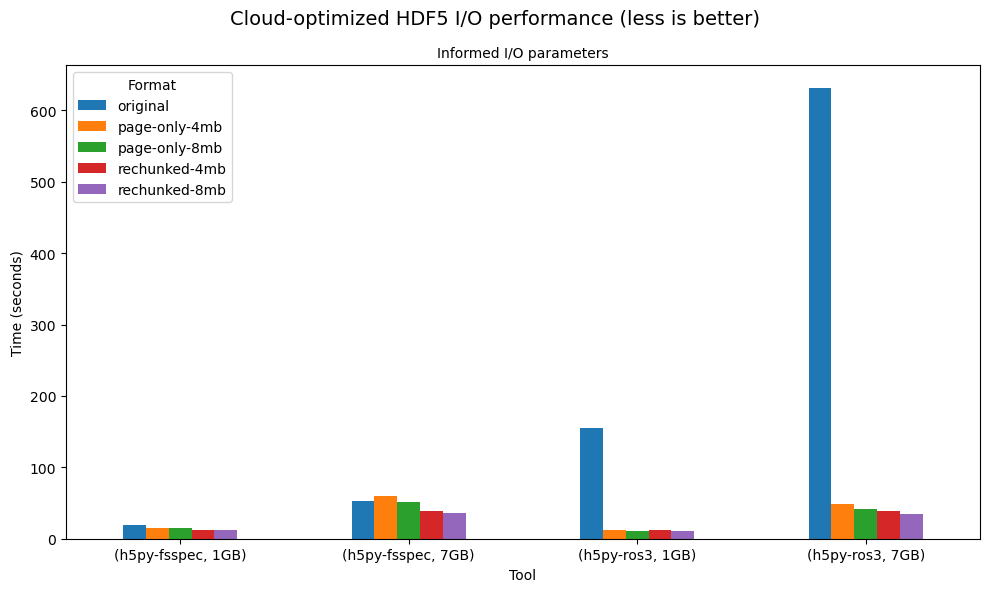

In [7]:
df = pd.DataFrame.from_dict(h5py_ros3_benchmarks + h5py_fsspec_benchmarks)

pivot_df = df.pivot_table(index=['tool','dataset'], columns=['format'], values='time', aggfunc='mean')

# Plotting
pivot_df.plot(kind='bar', figsize=(10, 6))

plt.suptitle('Cloud-optimized HDF5 I/O performance (less is better)', fontsize=14)
plt.title("Informed I/O parameters", fontsize=10)
plt.xlabel('Tool')
plt.ylabel('Time (seconds)')
plt.xticks(rotation=0)
plt.legend(title='Format')
plt.tight_layout()
ax = plt.gca()
plt.grid(False)
# ax.yaxis.grid(True)

plt.show()